# Jupyter Notebook with BigQuery

In [ ]:
import google.cloud.bigquery
import pandas as pd

PROJECT = 'ozkary-de-101'
DATASET = 'mta_data'

## Query the current records

In [ ]:
# using the bigquery client library read a list of tables 
# in the bigquery-public-data:samples dataset
client = google.cloud.bigquery.Client()
dataset_ref = client.dataset(DATASET, project=PROJECT)
tables = list(client.list_tables(dataset_ref))
for table in tables:
    print(table.table_id)

In [ ]:
# get the tables in the system and for each table get the schema
# and print the table name and row count
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    table = client.get_table(table_ref)
    print(table.schema)

# for each table get the row count
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    table = client.get_table(table_ref)
    print(table.table_id, table.num_rows)

In [ ]:
# define a run query function
def run_query(sql):
    query = client.query(sql)
    return query.to_dataframe()
    

In [ ]:
# use sql to query the latest date in the fact_turnstile table and print the result using the client reference
sql = """
SELECT max(created_dt) as max_date
FROM `{}.{}.fact_turnstile`
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(df.head())

In [59]:
# define todays date using a datetime object
from datetime import datetime, timedelta

# set a variable to the current date - 1 month
last_month = datetime.today() - timedelta(days=30)
date_value = last_month.strftime('%Y-%m-%d')

# select a limit of 100 rows with the latest date
sql = """
SELECT *
FROM `{}.{}.fact_turnstile`
WHERE created_dt >= '{}'
LIMIT 100
""".format(PROJECT, DATASET, date_value)    
df = run_query(sql)
print(df.head())

                             log_id                        station_id  \
0  cef2888c8e411bde51529ae402807860  fd372c646a361911880edb471b9287e7   
1  53bad7c50932c2ed2451f5ee586a639c  fd372c646a361911880edb471b9287e7   
2  530a091905f41db0271424a98813d0e3  fd372c646a361911880edb471b9287e7   
3  97c800d4ad7bbae7bbe7972cc51746d6  fd372c646a361911880edb471b9287e7   
4  04bdf964098c1d1c49886bd7bf79189e  fd372c646a361911880edb471b9287e7   

                           booth_id       scp line_name division  \
0  14ca865c7e9367b8c13b53d35ff58cb4  00-00-00         7      IRT   
1  14ca865c7e9367b8c13b53d35ff58cb4  00-00-00         7      IRT   
2  14ca865c7e9367b8c13b53d35ff58cb4  00-00-00         7      IRT   
3  14ca865c7e9367b8c13b53d35ff58cb4  00-00-00         7      IRT   
4  14ca865c7e9367b8c13b53d35ff58cb4  00-00-00         7      IRT   

                 created_dt  entries    exits  
0 2023-09-29 08:00:00+00:00  6046937  5021121  
1 2023-09-29 16:00:00+00:00  6047143  5021712  
2 2023-0

In [34]:
# print the dataframe in a grid format
def print_df(df):
    from IPython.display import display, HTML
    display(HTML(df.head().to_html()))

In [60]:
print_df(df)

,log_id,station_id,booth_id,scp,line_name,division,created_dt,entries,exits
0,cef2888c8e411bde51529ae402807860,fd372c646a361911880edb471b9287e7,14ca865c7e9367b8c13b53d35ff58cb4,00-00-00,7,IRT,2023-09-29 08:00:00+00:00,6046937,5021121
1,53bad7c50932c2ed2451f5ee586a639c,fd372c646a361911880edb471b9287e7,14ca865c7e9367b8c13b53d35ff58cb4,00-00-00,7,IRT,2023-09-29 16:00:00+00:00,6047143,5021712
2,530a091905f41db0271424a98813d0e3,fd372c646a361911880edb471b9287e7,14ca865c7e9367b8c13b53d35ff58cb4,00-00-00,7,IRT,2023-09-29 04:00:00+00:00,6046875,5020881
3,97c800d4ad7bbae7bbe7972cc51746d6,fd372c646a361911880edb471b9287e7,14ca865c7e9367b8c13b53d35ff58cb4,00-00-00,7,IRT,2023-09-29 00:00:00+00:00,6046873,5020879
4,04bdf964098c1d1c49886bd7bf79189e,fd372c646a361911880edb471b9287e7,14ca865c7e9367b8c13b53d35ff58cb4,00-00-00,7,IRT,2023-09-29 12:00:00+00:00,6047072,5021465


In [61]:
# join the fact_turnstile table with the dim_station table and dim_booth table for the last three months

sql = """
SELECT station_name, booth_name, created_dt, entries, exits
FROM `{}.{}.fact_turnstile` as f
JOIN `{}.{}.dim_station` as s
ON f.station_id = s.station_id
JOIN `{}.{}.dim_booth` as b
ON f.booth_id = b.booth_id
WHERE created_dt >= '{}'
LIMIT 1000
""".format(PROJECT, DATASET, PROJECT, DATASET, PROJECT, DATASET, date_value)
df_station = run_query(sql)
print_df(df_station)



,station_name,booth_name,created_dt,entries,exits
0,VERNON-JACKSON,R504,2023-09-29 08:00:00+00:00,6046937,5021121
1,VERNON-JACKSON,R504,2023-09-29 16:00:00+00:00,6047143,5021712
2,VERNON-JACKSON,R504,2023-09-29 04:00:00+00:00,6046875,5020881
3,VERNON-JACKSON,R504,2023-09-29 00:00:00+00:00,6046873,5020879
4,VERNON-JACKSON,R504,2023-09-29 12:00:00+00:00,6047072,5021465


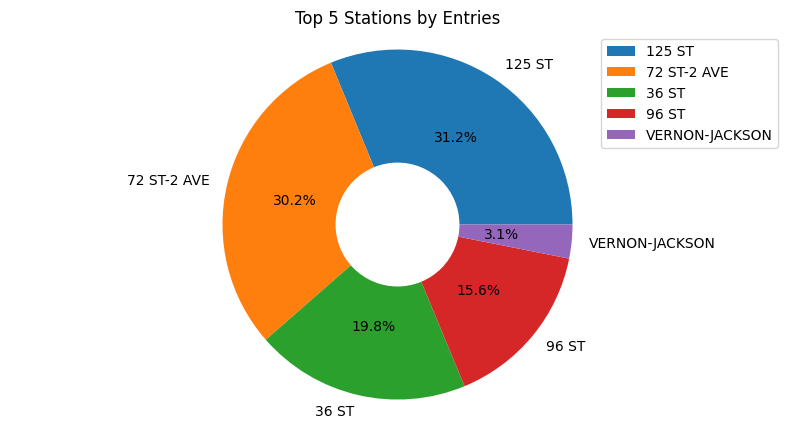

In [70]:

# get the top n stations with the most entries using the df_station dataframe
df_top_entries = df_station.groupby('station_name')['entries'].sum().reset_index().sort_values(by='entries', ascending=False).head(5)

# create a pie chart using the df_top_entries dataframe 
import matplotlib.pyplot as plt

# set the size of the pie chart
plt.figure(figsize=(10,5))

plt.pie(df_top_entries['entries'], labels=df_top_entries['station_name'], autopct='%1.1f%%')
plt.axis('equal')

# add a donut hole to the pie chart
my_circle=plt.Circle( (0,0), 0.35, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


# add a title and legend to the pie chart
plt.title('Top 5 Stations by Entries')
plt.legend(df_top_entries['station_name'], loc='upper right')

plt.show()

